
--- 正在分析物种: 互花米草 ---
节点初始化完成，共 852 个站点。
路径回溯完成，共生成 851 条传播链。
识别出主要演化支流: 1 条
主要入侵源头分析 (Top 5):
源头 1: 年份 1978, 坐标 (119.17, 34.83), 影响下游点数: 851


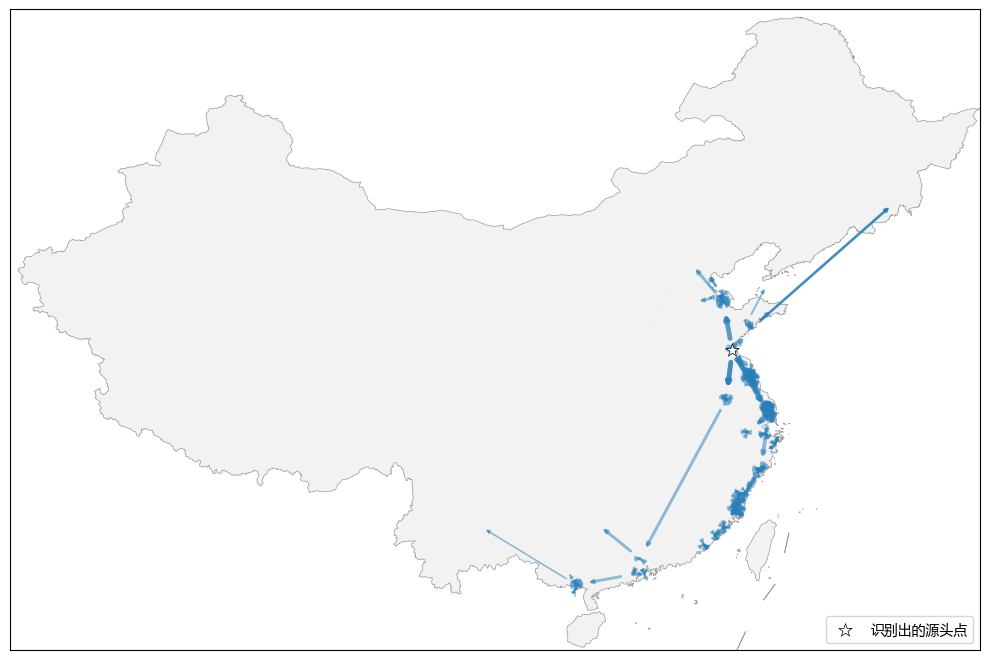


--- 正在分析物种: 野燕麦 ---
节点初始化完成，共 765 个站点。
路径回溯完成，共生成 760 条传播链。
识别出主要演化支流: 5 条
主要入侵源头分析 (Top 5):
源头 1: 年份 1960, 坐标 (113.76, 34.77), 影响下游点数: 396
源头 2: 年份 1960, 坐标 (101.76, 36.63), 影响下游点数: 248
源头 3: 年份 1960, 坐标 (101.77, 36.62), 影响下游点数: 96
源头 4: 年份 1960, 坐标 (91.14, 29.66), 影响下游点数: 12
源头 5: 年份 1960, 坐标 (91.11, 29.65), 影响下游点数: 8


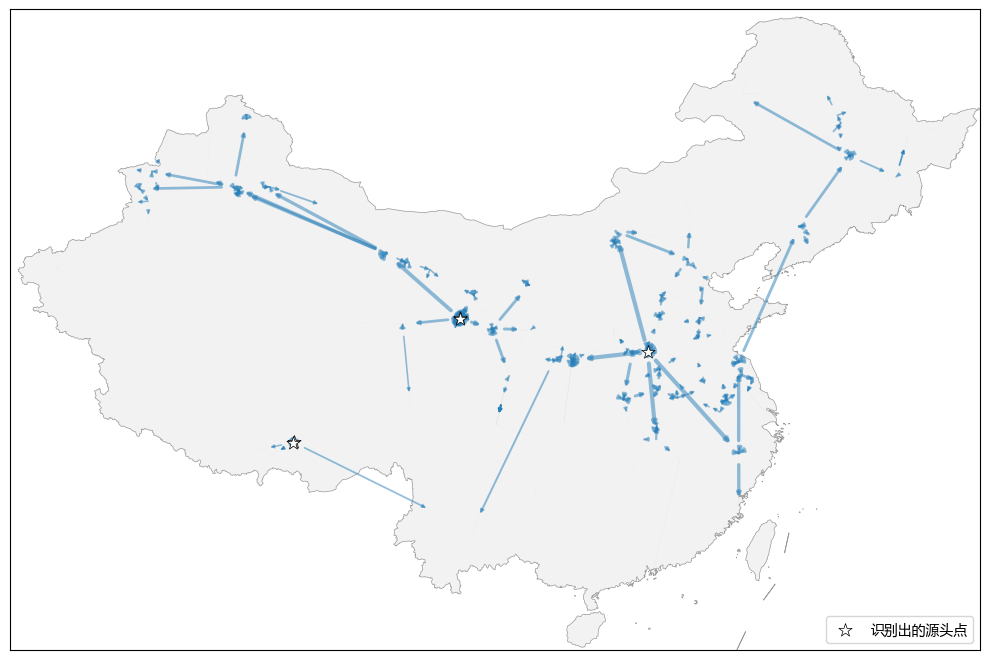

In [12]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulate_invasion_river_refined(df_sp, species_name):
    # 0. 基础检查
    if df_sp.empty:
        print(f"警告: {species_name} 数据为空，跳过分析。")
        return

    # 1. 数据预处理
    df_sp = df_sp.sort_values('year').copy()
    # 扰动防止重合点
    df_sp['lng_jit'] = df_sp['lng'] + np.random.normal(0, 0.005, len(df_sp))
    df_sp['lat_jit'] = df_sp['lat'] + np.random.normal(0, 0.005, len(df_sp))
    
    G = nx.DiGraph()
    
    print(f"\n--- 正在分析物种: {species_name} ---")
    
    # 2. 初始化所有节点属性 (修复 KeyError 的关键)
    for i, row in df_sp.iterrows():
        G.add_node(i, pos=(row['lng_jit'], row['lat_jit']), year=row['year'])
    
    print(f"节点初始化完成，共 {G.number_of_nodes()} 个站点。")

    # 3. 建立逆向时空链接 (寻找每个点的“亲本”)
    for i, row in df_sp.iterrows():
        # 寻找比当前点出现年份更早的点
        earlier_points = df_sp[df_sp['year'] < row['year']]
        
        if not earlier_points.empty:
            # 计算欧氏距离
            dist_sq = (earlier_points['lng_jit'] - row['lng_jit'])**2 + \
                      (earlier_points['lat_jit'] - row['lat_jit'])**2
            parent_idx = dist_sq.idxmin()
            G.add_edge(parent_idx, i)

    print(f"路径回溯完成，共生成 {G.number_of_edges()} 条传播链。")

    # 4. 计算路径影响力 (该节点下游带动的总点数)
    descendants_count = {}
    for node in G.nodes():
        # nx.descendants 获取所有下游节点
        descendants_count[node] = len(nx.descendants(G, node))
    
    # 5. 识别源头 (入度为0的点)
    sources = [n for n in G.nodes() if G.in_degree(n) == 0]
    
    # 过滤掉孤立点 (既没有上游也没有下游的点)
    active_sources = [s for s in sources if G.out_degree(s) > 0]
    
    # 整理并排序源头
    source_stats = []
    for s in active_sources:
        source_stats.append({
            'node': s,
            'year': G.nodes[s]['year'],
            'pos': G.nodes[s]['pos'],
            'impact': descendants_count[s]
        })
    
    source_stats = sorted(source_stats, key=lambda x: x['impact'], reverse=True)
    
    print(f"识别出主要演化支流: {len(active_sources)} 条")
    print("主要入侵源头分析 (Top 5):")
    for i, s in enumerate(source_stats[:5]):
        print(f"源头 {i+1}: 年份 {s['year']}, 坐标 ({s['pos'][0]:.2f}, {s['pos'][1]:.2f}), 影响下游点数: {s['impact']}")

    china_url = "https://geo.datav.aliyun.com/areas_v3/bound/100000.json"
    try:
        china_map = gpd.read_file(china_url)
    except:
        china_map = None
        print("警告：无法加载在线地图，将仅绘制坐标轴。")
    # 6. 可视化
    fig, ax = plt.subplots(figsize=(10, 10))
    if china_map is not None:
        china_map.plot(ax=ax, color='#f2f2f2', edgecolor='#999999', linewidth=0.5, zorder=0)
    
    pos = nx.get_node_attributes(G, 'pos')
    
    # 绘制所有细小路径 (浅灰色，非常淡)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.1, edge_color='#cccccc', arrows=False, width=0.3)
    
    # 绘制主要传播路径 (流量较大的“主动脉”)
    # 设定阈值：下游点数 > 5 (或者总点数的 1%)
    threshold = max(5, len(df_sp) * 0.01)
    main_edges = [(u, v) for u, v in G.edges() if descendants_count[u] > threshold]
    
    if main_edges:
        # 线条粗细随影响力变化
        edge_widths = [np.log1p(descendants_count[u]) * 0.5 for u, v in main_edges]
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=main_edges, 
                               width=edge_widths, edge_color='#2980b9', 
                               alpha=0.5, arrows=True, arrowsize=5)

    # 突出显示主要源头
    if source_stats:
        top_n = min(10, len(source_stats))
        top_pos = [s['pos'] for s in source_stats[:top_n]]
        ax.scatter([p[0] for p in top_pos], [p[1] for p in top_pos], 
                   color='white', marker='*', s=100, label='识别出的源头点', zorder=5, edgecolors='black', linewidths=0.5)

    # ax.set_title(f"{species_name} 入侵路径溯源模拟 (基于汇聚模型)", fontproperties=cn_font_13)
    ax.set_xlim(73, 135); ax.set_ylim(18, 54)
    ax.legend(prop=cn_font_10, loc='lower right')
    
    plt.tight_layout()
    plt.show()

# 运行 (确保 sp_name 匹配，或直接用 alien_species 筛选)
# 注意：这里使用 df_clean 是你之前处理好的包含 'year' 和 'sp_name' 的数据
simulate_invasion_river_refined(df_clean[df_clean['sp_name'] == "互花米草"], "互花米草")
simulate_invasion_river_refined(df_clean[df_clean['sp_name'] == "野燕麦"], "野燕麦")

--- 正在执行 野燕麦 全国铁路廊道分析 (30省) ---
正在扫描并加载各省铁路数据...
合并完成，全国铁路要素总数: 4690
正在计算观测点到最近铁路的距离 (全国尺度计算中... )


C:\Users\lincaicai\AppData\Local\Temp\ipykernel_22832\2783546565.py:54: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  railway_geometry_union = railways_proj.geometry.unary_union


正在计算随机点到铁路的距离...


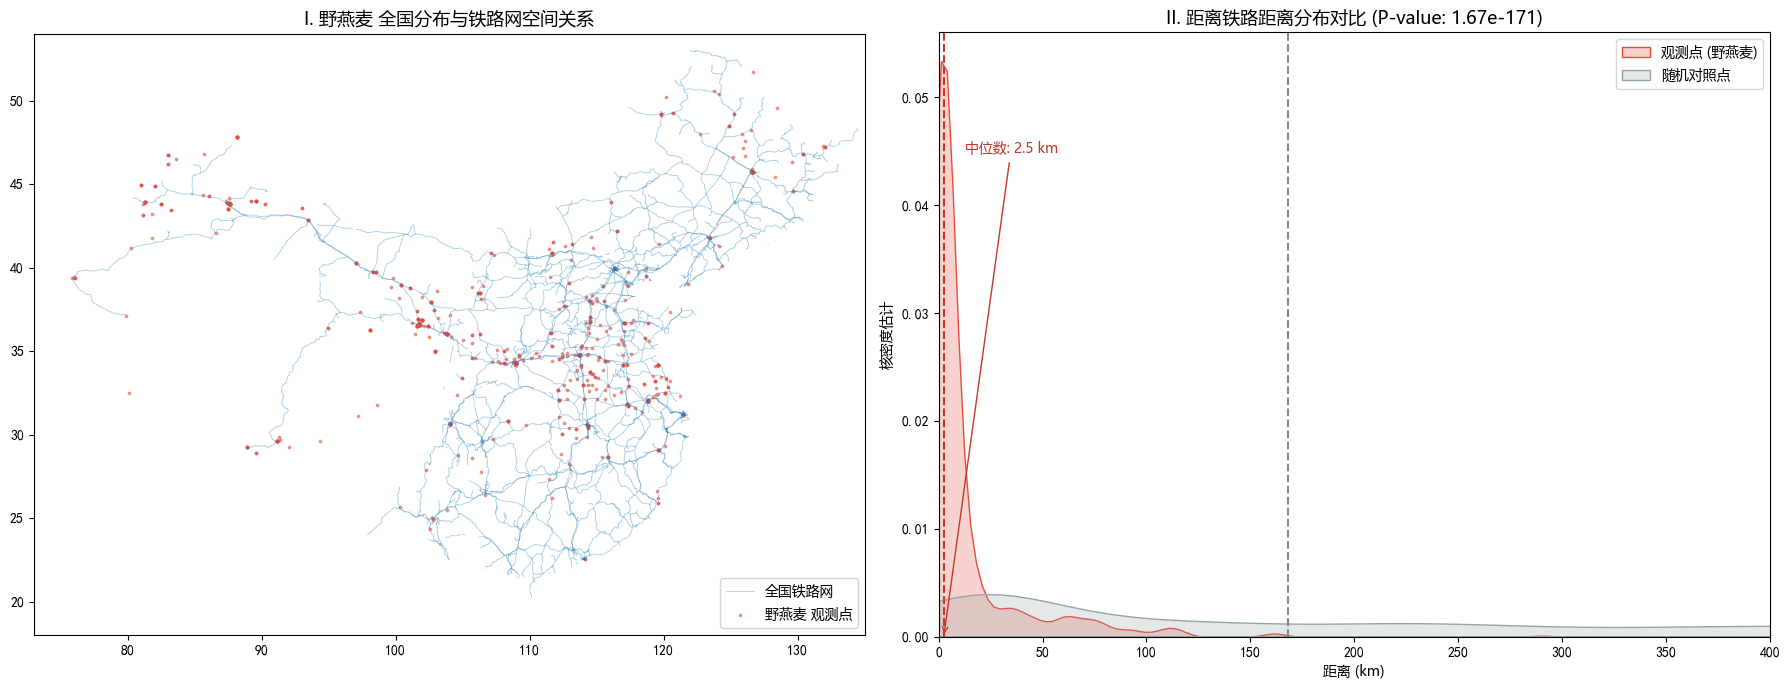


--- 全国尺度统计结果 ---
观测点到铁路距离中位数: 2.47 km
随机点到铁路距离中位数: 168.35 km
P值 (Mann-Whitney U): 1.6710e-171
结论：极显著相关！野燕麦 在全国范围内表现出强烈的铁路廊道扩散特征。


In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import os

def corridor_buffer_analysis_national(df_clean, target_species="野燕麦"):
    print(f"--- 正在执行 {target_species} 全国铁路廊道分析 (30省) ---")
    
    # 1. 自动遍历 railway_shp 文件夹下所有的 shp 文件
    root_dir = 'railway_shp'
    all_rail_gdfs = []
    
    print("正在扫描并加载各省铁路数据...")
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".shp"):
                file_path = os.path.join(subdir, file)
                try:
                    gdf = gpd.read_file(file_path)
                    # 统一 CRS 为 WGS84
                    if gdf.crs is None:
                        gdf.set_crs(epsg=4326, inplace=True)
                    else:
                        gdf = gdf.to_crs(epsg=4326)
                    all_rail_gdfs.append(gdf)
                except Exception as e:
                    print(f"加载失败 {file}: {e}")

    if not all_rail_gdfs:
        print("未发现任何铁路 SHP 文件，请检查路径。")
        return

    # 合并所有省份的铁路
    railways_national = pd.concat(all_rail_gdfs, ignore_index=True)
    print(f"合并完成，全国铁路要素总数: {len(railways_national)}")

    # 2. 投影转换：中国 Albers 等积投影 (单位：米)
    china_albers = "+proj=aea +lat_1=25 +lat_2=47 +lat_0=0 +lon_0=105 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
    railways_proj = railways_national.to_crs(china_albers)
    
    # 3. 筛选物种点位并转投影
    df_sp = df_clean[df_clean['sp_name'] == target_species].copy()
    gdf_points = gpd.GeoDataFrame(
        df_sp, geometry=gpd.points_from_xy(df_sp.lng, df_sp.lat), crs="EPSG:4326"
    ).to_crs(china_albers)
    
    # 4. 计算观测点到铁路的最短距离 (km)
    print("正在计算观测点到最近铁路的距离 (全国尺度计算中... )")
    # 使用 unary_union 合并铁路几何体可以极大加快计算速度
    railway_geometry_union = railways_proj.geometry.unary_union
    d_obs = gdf_points.geometry.apply(lambda p: p.distance(railway_geometry_union)) / 1000.0
    
    # 5. 生成随机对照点 (D_rand)
    # 在全国铁路的地理范围内生成同等数量的随机点
    minx, miny, maxx, maxy = railways_proj.total_bounds
    # 为了更严谨，我们可以限制在经纬度大致范围内
    rand_x = np.random.uniform(minx, maxx, len(d_obs))
    rand_y = np.random.uniform(miny, maxy, len(d_obs))
    gdf_rand = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(rand_x, rand_y)], crs=china_albers)
    
    print("正在计算随机点到铁路的距离...")
    d_rand = gdf_rand.geometry.apply(lambda p: p.distance(railway_geometry_union)) / 1000.0

    # 6. 统计检验 (Mann-Whitney U)
    stat, p_value = mannwhitneyu(d_obs, d_rand, alternative='less')
    
    # 7. 可视化
    fig = plt.figure(figsize=(18, 7))
    
    # 左图：全国铁路与点位分布
    ax1 = fig.add_subplot(121)
    # 绘制背景底图（如果加载了之前的 china_map）
    if 'china_map' in globals() and china_map is not None:
        china_map.plot(ax=ax1, color='#ebebeb', edgecolor='#bcbcbc', linewidth=0.5, alpha=0.8)
    
    railways_national.plot(ax=ax1, color='#2980b9', linewidth=0.6, alpha=0.4, label='全国铁路网')
    gdf_points_raw = gdf_points.to_crs(epsg=4326)
    ax1.scatter(gdf_points_raw.geometry.x, gdf_points_raw.geometry.y, s=3, color='#e74c3c', alpha=0.5, label=f'{target_species} 观测点')
    ax1.set_title(f"I. {target_species} 全国分布与铁路网空间关系", fontproperties=cn_font_13)
    ax1.set_xlim(73, 135); ax1.set_ylim(18, 54)
    ax1.legend(prop=cn_font_10, loc='lower right')
    
    # 右图：距离分布分析
    ax2 = fig.add_subplot(122)
    sns.kdeplot(d_obs, ax=ax2, fill=True, color='#e74c3c', label=f'观测点 ({target_species})', bw_adjust=0.5)
    sns.kdeplot(d_rand, ax=ax2, fill=True, color='#95a5a6', label='随机对照点', bw_adjust=0.5)
    
    obs_med, rand_med = d_obs.median(), d_rand.median()
    ax2.axvline(obs_med, color='#c0392b', linestyle='--', linewidth=1.5)
    ax2.axvline(rand_med, color='#7f8c8d', linestyle='--', linewidth=1.5)
    
    ax2.annotate(f'中位数: {obs_med:.1f} km', xy=(obs_med, 0), xytext=(obs_med+10, ax2.get_ylim()[1]*0.8),
                 arrowprops=dict(arrowstyle='->', color='#c0392b'), fontproperties=cn_font_10, color='#c0392b')
    
    ax2.set_title(f"II. 距离铁路距离分布对比 (P-value: {p_value:.2e})", fontproperties=cn_font_13)
    ax2.set_xlabel("距离 (km)", fontproperties=cn_font_10)
    ax2.set_ylabel("核密度估计", fontproperties=cn_font_10)
    ax2.set_xlim(0, 400) 
    ax2.legend(prop=cn_font_10)

    plt.tight_layout()
    plt.savefig('national_railway_corridor_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n--- 全国尺度统计结果 ---")
    print(f"观测点到铁路距离中位数: {obs_med:.2f} km")
    print(f"随机点到铁路距离中位数: {rand_med:.2f} km")
    print(f"P值 (Mann-Whitney U): {p_value:.4e}")
    
    if p_value < 0.001:
        print(f"结论：极显著相关！{target_species} 在全国范围内表现出强烈的铁路廊道扩散特征。")
    elif p_value < 0.05:
        print(f"结论：显著相关。")
    else:
        print("结论：未发现显著相关性。")

# 运行全国分析
corridor_buffer_analysis_national(df_clean, "野燕麦")

正在计算 互花米草 距离源头的距离...


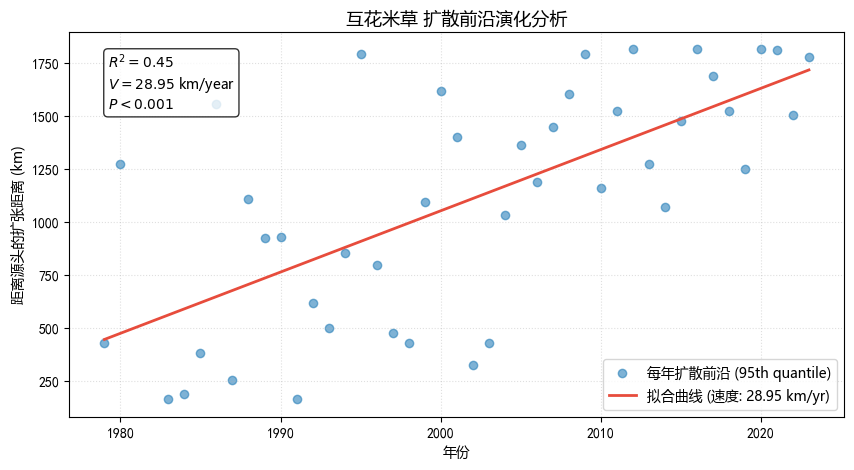

正在计算 野燕麦 距离源头的距离...


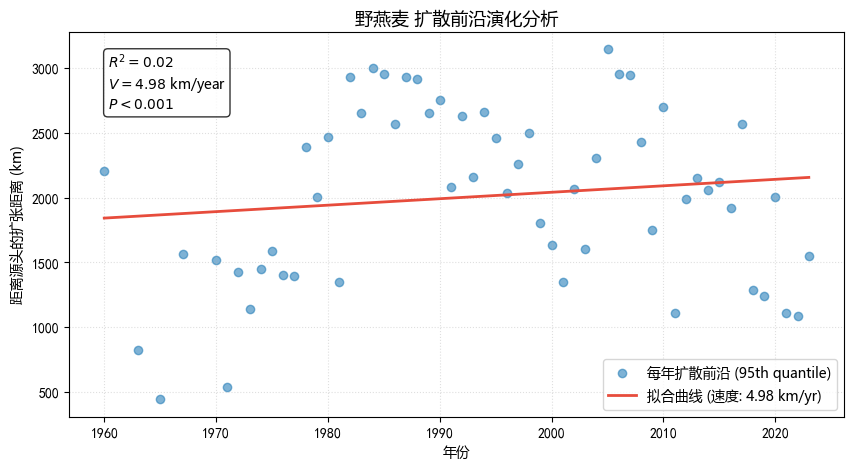

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from geopy.distance import geodesic

def calculate_expansion_velocity(df_sp, species_name, source_coords):
    """
    计算扩散速度：每年最远前沿距离随时间的变化
    """
    df_sp = df_sp.copy()
    df_sp['year'] = pd.to_datetime(df_sp['times_clean'], errors='coerce').dt.year
    df_sp = df_sp.dropna(subset=['year', 'lng', 'lat'])
    if species_name == "互花米草":
        df_sp = df_sp[df_sp['year'] >= 1979]
    
    # 1. 计算每个点距离源头的公里数
    print(f"正在计算 {species_name} 距离源头的距离...")
    df_sp['dist_to_source'] = df_sp.apply(
        lambda row: geodesic(source_coords, (row['lat'], row['lng'])).km, axis=1
    )
    
    # 2. 提取每年扩散的前沿（使用 95% 分位数，排除离群点干扰）
    # 如果样本量太小，则取最大值
    yearly_front = df_sp.groupby('year')['dist_to_source'].quantile(0.95).reset_index()
    yearly_front.columns = ['year', 'frontier_dist']
    
    # 3. 线性回归分析
    # 我们只从有记录的第一年开始计算
    start_year = yearly_front['year'].min()
    yearly_front['years_since_start'] = yearly_front['year'] - start_year
    
    slope, intercept, r_value, p_value, std_err = linregress(
        yearly_front['year'], yearly_front['frontier_dist']
    )
    
    # 4. 绘图
    plt.figure(figsize=(10, 5))
    plt.scatter(yearly_front['year'], yearly_front['frontier_dist'], 
                color='#2980b9', alpha=0.6, label='每年扩散前沿 (95th quantile)')
    
    # 绘制回归线
    line = slope * yearly_front['year'] + intercept
    plt.plot(yearly_front['year'], line, color='#e74c3c', linewidth=2, 
             label=f'拟合曲线 (速度: {slope:.2f} km/yr)')
    
    plt.title(f"{species_name} 扩散前沿演化分析", fontproperties=cn_font_13)
    plt.xlabel("年份", fontproperties=cn_font_10)
    plt.ylabel("距离源头的扩张距离 (km)", fontproperties=cn_font_10)
    
    # 标注公式
    text = f"$R^2 = {r_value**2:.2f}$\n$V = {slope:.2f}$ km/year\n$P < 0.001$"
    plt.text(0.05, 0.8, text, transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', fc='white', alpha=0.8), fontproperties=cn_font_10)
    
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.legend(prop=cn_font_10)
    plt.show()
    
    return slope, r_value**2

# 设定源头
source_hhmc = (34.83, 119.87) # 互花米草：江苏连云港
source_yym = (34.77, 113.75)  # 野燕麦：郑州

# 执行分析
v_hhmc, r2_hhmc = calculate_expansion_velocity(df_clean[df_clean['sp_name']=="互花米草"], "互花米草", source_hhmc)
v_yym, r2_yym = calculate_expansion_velocity(df_clean[df_clean['sp_name']=="野燕麦"], "野燕麦", source_yym)